Visualization of G and D matrices for unimanual conditions

In [1]:
import os
import glob
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/PcmPy')
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Unimanual 6by6

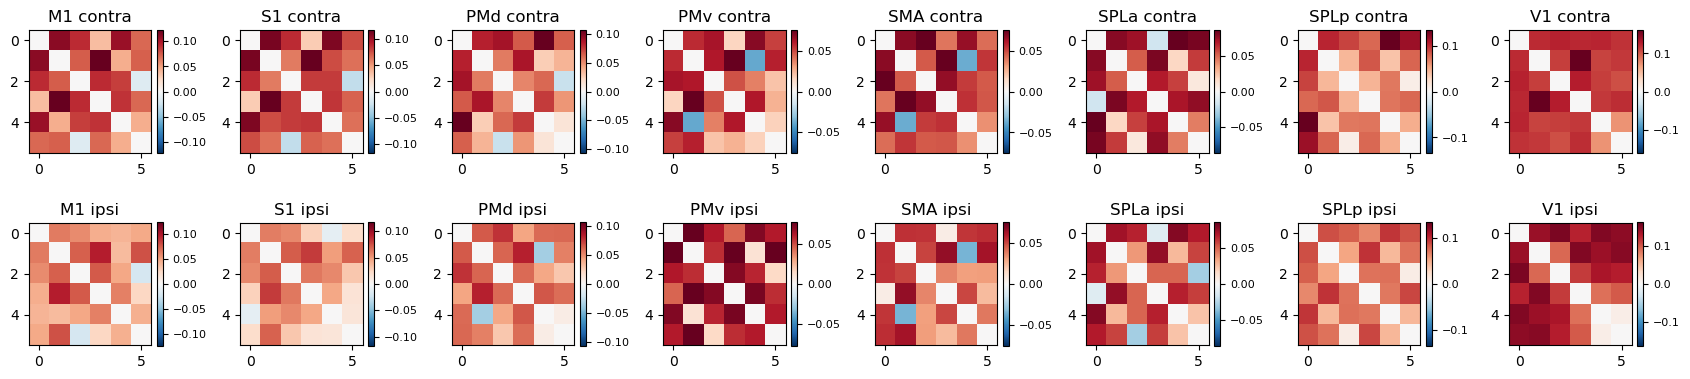

In [8]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
sn_bad = [102,103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
conditions = ['lhand','rhand','lhand','rhand']

dataset_unimanual_within = {'region':[], 'hem': [], 'type': [], 'labels': [], 'Y': []}
RDMs_uni = {'region':[], 'labels': [], 'G': [], 'D': []}

for i_region, region in enumerate(regions):
    rois = [f'{region}_R', f'{region}_L', f'{region}_L', f'{region}_R']
    for roi, condition in zip(rois, conditions):
        data, cond_vec, part_vec = [], [], []
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            if condition == 'lhand':
                if roi.endswith('_R'):
                    cond_type = 'contra'
                else:
                    cond_type = 'ipsi'
            if condition == 'rhand':
                if roi.endswith('_L'):
                    cond_type = 'contra'
                else:
                    cond_type = 'ipsi'
            
            # Filter for the current condition
            idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
            Y = data_tmp[i_sub][idx, :]
            subj_cond = cond_vec_tmp[i_sub][idx]
            subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

        Y = []
        # --- RDM Calculation ---
        for i_sub in range(len(data)):
            obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
            Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
        
        dataset_unimanual_within['region'].append(region)
        dataset_unimanual_within['hem'].append(roi[-1])
        dataset_unimanual_within['type'].append(cond_type)
        dataset_unimanual_within['labels'].append(labels)
        dataset_unimanual_within['Y'].append(Y)

dataset_unimanual_within = pd.DataFrame(dataset_unimanual_within)
dataset_unimanual_within.to_pickle(os.path.join(analysisDir, 'dataset_unimanual_within.pkl'))

# --- RDM Calculation ---
fig, axes = plt.subplots(2, len(regions), figsize=(17,4))
for i, region in enumerate(regions):
    subset = dataset_unimanual_within[(dataset_unimanual_within['region'] == f'{region}') & 
                                        (dataset_unimanual_within['type'] == 'contra')]
    Y1 = subset['Y'].iloc[0]
    Y2 = subset['Y'].iloc[1]
    Y = Y1 + Y2  # concatenate the two lists of datasets
    labels = subset['labels'].iloc[0]
    N = len(Y)
    ncond = len(labels)
    G_hat = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                    Y[i_sub].obs_descriptors['cond_vec'],
                                                    Y[i_sub].obs_descriptors['part_vec'],
                                                    X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
    
    G_hat_avg = np.mean(G_hat, axis=0)
    D_avg = pcm.G_to_dist(G_hat_avg)
    D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
    vmin = -np.max(np.abs(D_avg))
    vmax = np.max(np.abs(D_avg))
    axes[0, i].imshow(D_avg,vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[0, i], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    axes[0, i].set_title(f'{region} contra')

    subset = dataset_unimanual_within[(dataset_unimanual_within['region'] == f'{region}') & 
                                        (dataset_unimanual_within['type'] == 'ipsi')]
    Y1 = subset['Y'].iloc[0]
    Y2 = subset['Y'].iloc[1]
    Y = Y1 + Y2  # concatenate the two lists of datasets
    labels = subset['labels'].iloc[0]
    N = len(Y)
    ncond = len(labels)
    G_hat = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                    Y[i_sub].obs_descriptors['cond_vec'],
                                                    Y[i_sub].obs_descriptors['part_vec'],
                                                    X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
    G_hat_avg = np.mean(G_hat, axis=0)
    D_avg = pcm.G_to_dist(G_hat_avg)
    D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
    axes[1, i].imshow(D_avg,vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1, i], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    axes[1, i].set_title(f'{region} ipsi')

plt.tight_layout()
plt.show()



# Unimanual contra

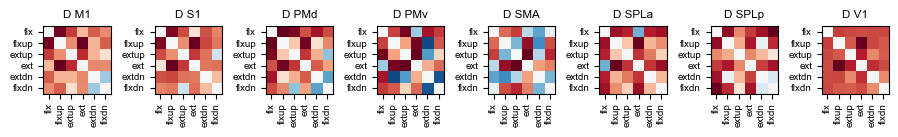

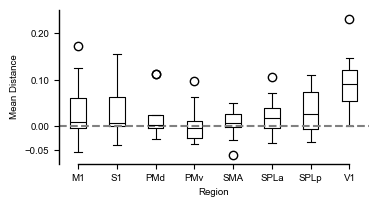

In [ ]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
sn_bad = [102,103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
conditions = ['rhand']
df = {'sn':[], 'roi':[], 'hem':[], 'distances':[], 'mean_distance':[]}

RDMs_contra = {'region':[], 'labels': [], 'G': [], 'D': []}

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
fig, axes = plt.subplots(1, len(regions), figsize=(9,3))
for i_region, region in enumerate(regions):
    rois = [f'{region}_L']
    data, cond_vec, part_vec = [], [], []
    for roi, condition in zip(rois, conditions):
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            # Filter for the current condition
            if condition == 'lhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that left hand goes in that direction:
                        tmp_name = f'bi:{direction}_'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'lhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'rhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that right hand goes in that direction:
                        tmp_name = f'_{direction}'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'rhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'lhand' or condition == 'rhand':
                # Filter for the current condition
                idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
                Y = data_tmp[i_sub][idx, :]
                subj_cond = cond_vec_tmp[i_sub][idx]
                subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    # --- RDM Calculation ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
    
    N = len(Y)
    ncond = 6
    G_hat = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                    Y[i_sub].obs_descriptors['cond_vec'],
                                                    Y[i_sub].obs_descriptors['part_vec'],
                                                    X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
        dist = pcm.G_to_dist(G_hat[i_sub, :, :])
        dist = np.sign(dist) * np.sqrt(np.abs(dist))
        # select the upper triangle of d excluding the diagonal
        triu_indices = np.triu_indices(ncond, k=1)
        d_upper = dist[triu_indices]
        # save in df:
        df['distances'].append(d_upper)
        df['mean_distance'].append(np.mean(d_upper))
        df['roi'].append(region)
        # if i_sub is bigger than len of subject:
        if i_sub > len(subject)-1:
            df['sn'].append(subject[i_sub - len(subject)])
            df['hem'].append('R')
        else:
            df['sn'].append(subject[i_sub])
            df['hem'].append('L')

    G_hat_avg = np.mean(G_hat, axis=0)
    D_avg = pcm.G_to_dist(G_hat_avg)
    D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
    RDMs_contra['region'].append(region)
    RDMs_contra['G'].append(G_hat_avg)
    RDMs_contra['D'].append(D_avg)
    RDMs_contra['labels'].append(labels)

    vmin = -np.max(np.abs(D_avg))
    vmax = np.max(np.abs(D_avg))
    axes[i_region].imshow(D_avg, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    # plt.colorbar(axes[i_region].imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=axes[i_region])
    axes[i_region].set_title(f'D {region}')
    axes[i_region].set_xticks([0,1,2,3,4,5])
    axes[i_region].set_xticklabels(labels, rotation=90)
    axes[i_region].set_yticks([0,1,2,3,4,5])
    axes[i_region].set_yticklabels(labels)

plt.tight_layout()
plt.savefig('/Users/aghavamp/Desktop/Projects/bimanual_wrist/figures/RDMs/RDM_uni_contra.pdf', bbox_inches='tight')
plt.show()

df_contra = pd.DataFrame(df)

# Create a dot plot for the mean distances
fig, ax = plt.subplots(figsize=(4, 2))
sns.boxplot(data=df_contra, x='roi', y='mean_distance', ax=ax, fill=False, color='black', width=0.4, linewidth=0.8)
ax.axhline(0, color='grey', linestyle='--', linewidth=1.5)
ax.set_xlabel('Region')
ax.set_ylabel('Mean Distance')
plt.ylim(-0.08, 0.25)
ax.set_yticks([-0.05, 0, 0.1, 0.2])
utils.please.make_it_pretty(ax)
plt.savefig('/Users/aghavamp/Desktop/Projects/bimanual_wrist/figures/RDMs/avgdist_uni_contra.pdf', bbox_inches='tight')
plt.show()

RDMs_contra = pd.DataFrame(RDMs_contra)
RDMs_contra.to_pickle(os.path.join(analysisDir, 'RDMs_uni_contra.pkl'))



# Unimanual Ipsi

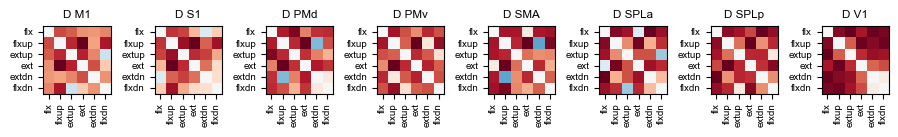

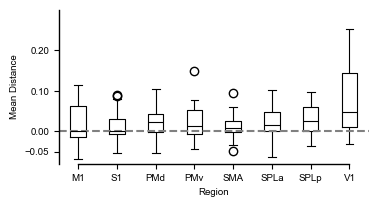

In [20]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
sn_bad = [102,103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
conditions = ['lhand','rhand']
df = {'sn':[], 'roi':[], 'hem':[], 'distances':[], 'mean_distance':[]}
RDMs_ipsi = {'region':[], 'labels': [], 'G': [], 'D': []}

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
fig, axes = plt.subplots(1, len(regions), figsize=(9,3))
for i_region, region in enumerate(regions):
    rois = [f'{region}_L', f'{region}_R']
    data, cond_vec, part_vec = [], [], []
    for roi, condition in zip(rois, conditions):
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            # Filter for the current condition
            if condition == 'lhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that left hand goes in that direction:
                        tmp_name = f'bi:{direction}_'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'lhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'rhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that right hand goes in that direction:
                        tmp_name = f'_{direction}'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'rhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'lhand' or condition == 'rhand':
                # Filter for the current condition
                idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
                Y = data_tmp[i_sub][idx, :]
                subj_cond = cond_vec_tmp[i_sub][idx]
                subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    # --- RDM Calculation ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
    
    N = len(Y)
    ncond = 6
    G_hat = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                    Y[i_sub].obs_descriptors['cond_vec'],
                                                    Y[i_sub].obs_descriptors['part_vec'],
                                                    X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
        dist = pcm.G_to_dist(G_hat[i_sub, :, :])
        dist = np.sign(dist) * np.sqrt(np.abs(dist))
        # select the upper triangle of d excluding the diagonal
        triu_indices = np.triu_indices(ncond, k=1)
        d_upper = dist[triu_indices]
        # save in df:
        df['distances'].append(d_upper)
        df['mean_distance'].append(np.mean(d_upper))
        df['roi'].append(region)
        # if i_sub is bigger than len of subject:
        if i_sub > len(subject)-1:
            df['sn'].append(subject[i_sub - len(subject)])
            df['hem'].append('R')
        else:
            df['sn'].append(subject[i_sub])
            df['hem'].append('L')

    G_hat_avg = np.mean(G_hat, axis=0)
    D_avg = pcm.G_to_dist(G_hat_avg)
    D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
    RDMs_ipsi['region'].append(region)
    RDMs_ipsi['G'].append(G_hat_avg)
    RDMs_ipsi['D'].append(D_avg)
    RDMs_ipsi['labels'].append(labels)

    vmin = -np.max(np.abs(D_avg))
    vmax = np.max(np.abs(D_avg))
    axes[i_region].imshow(D_avg, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    # plt.colorbar(axes[i_region].imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=axes[i_region])
    axes[i_region].set_title(f'D {region}')
    axes[i_region].set_xticks([0,1,2,3,4,5])
    axes[i_region].set_xticklabels(labels, rotation=90)
    axes[i_region].set_yticks([0,1,2,3,4,5])
    axes[i_region].set_yticklabels(labels)

plt.tight_layout()
plt.savefig('/Users/aghavamp/Desktop/Projects/bimanual_wrist/figures/RDMs/RDM_uni_ipsi.pdf', bbox_inches='tight')
plt.show()

df_ipsi = pd.DataFrame(df)
# Create a dot plot for the mean distances
fig, ax = plt.subplots(figsize=(4, 2))
sns.boxplot(data=df_ipsi, x='roi', y='mean_distance', ax=ax, fill=False, color='black', width=0.4, linewidth=0.8)
ax.axhline(0, color='grey', linestyle='--', linewidth=1.5)
ax.set_xlabel('Region')
ax.set_ylabel('Mean Distance')
plt.ylim(-0.08, 0.3)
ax.set_yticks([-0.05, 0, 0.1, 0.2])
utils.please.make_it_pretty(ax)
plt.savefig('/Users/aghavamp/Desktop/Projects/bimanual_wrist/figures/RDMs/avgdist_uni_ipsi.pdf', bbox_inches='tight')
plt.show()

RDMs_ipsi = pd.DataFrame(RDMs_ipsi)
RDMs_ipsi.to_pickle(os.path.join(analysisDir, 'RDMs_uni_ipsi.pkl'))



# Bimanual

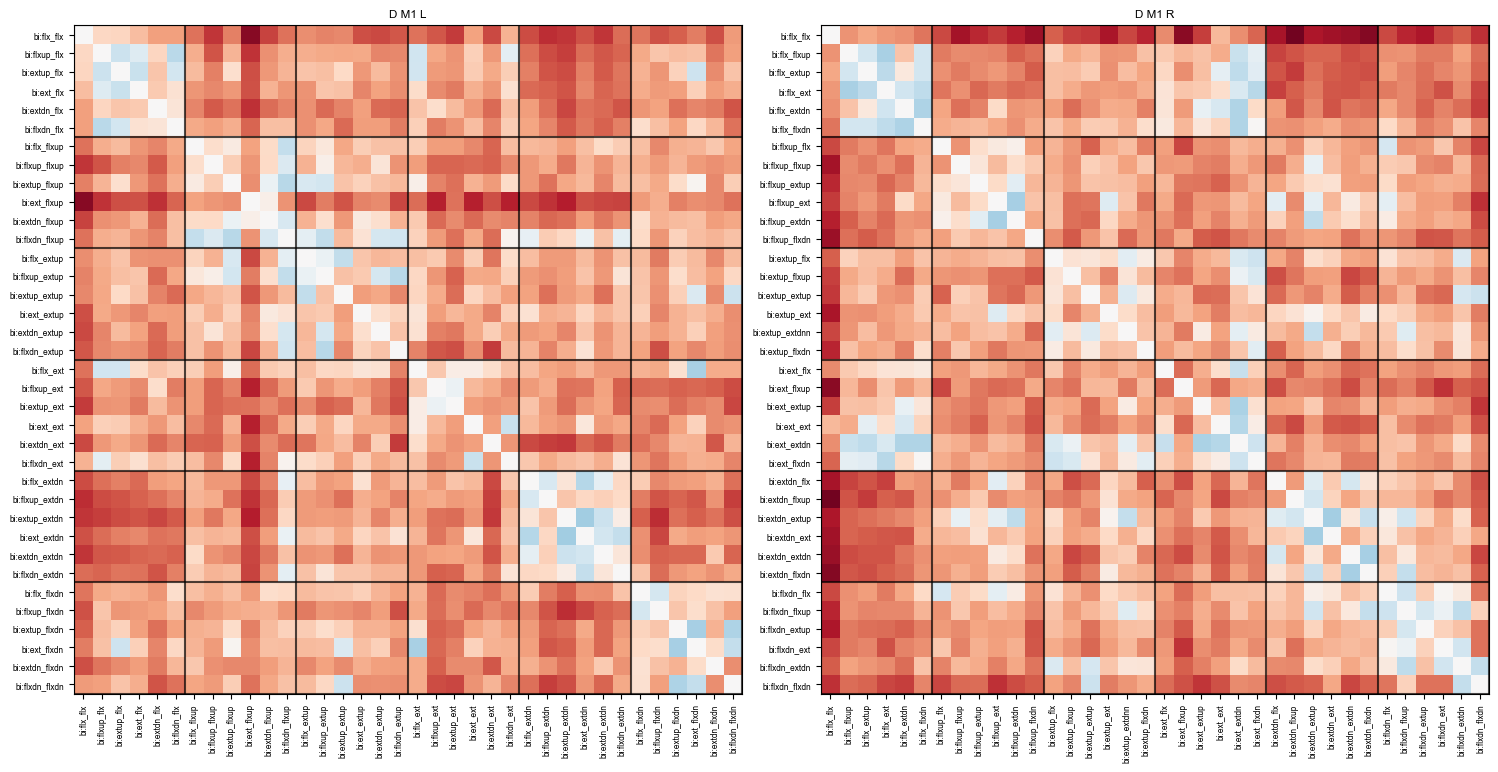

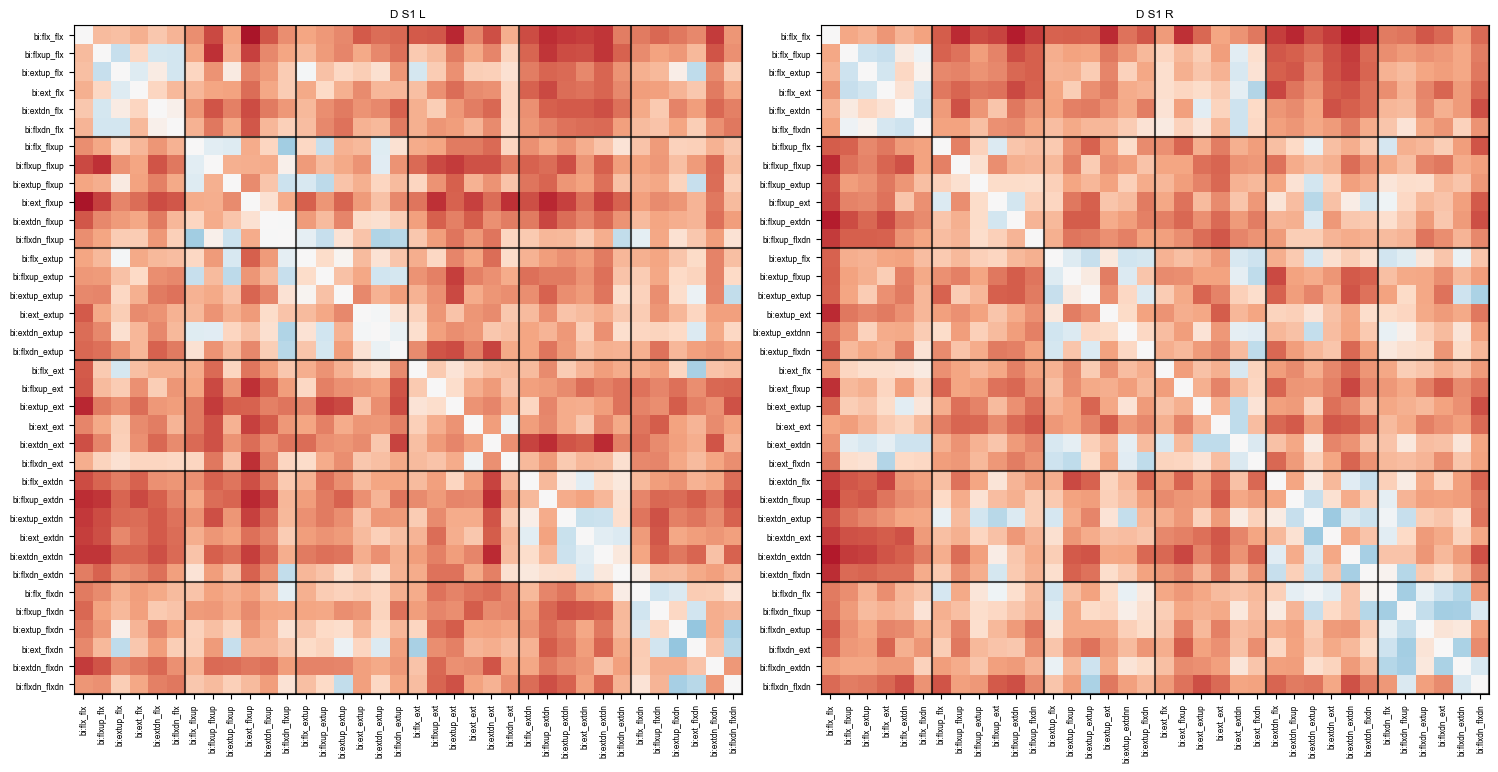

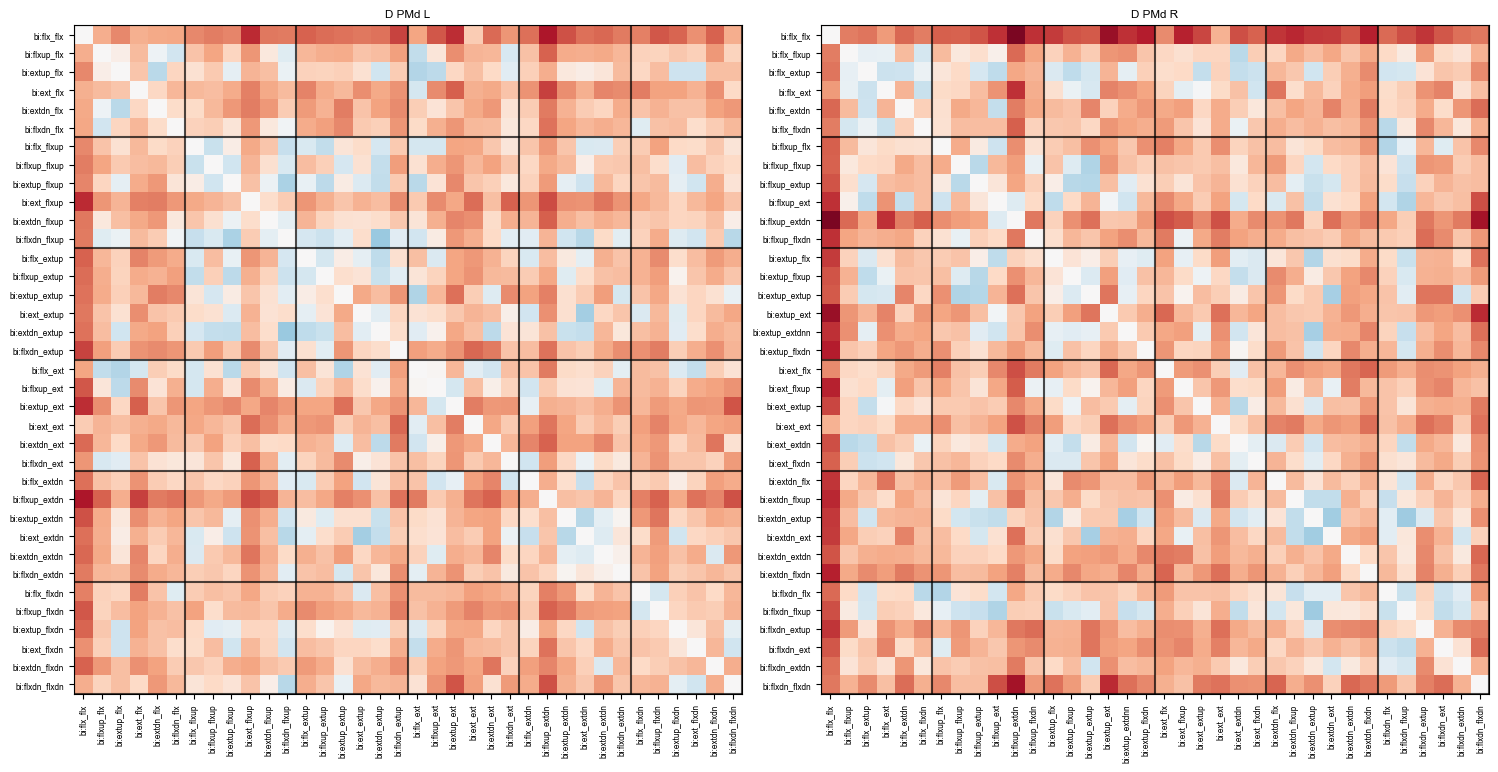

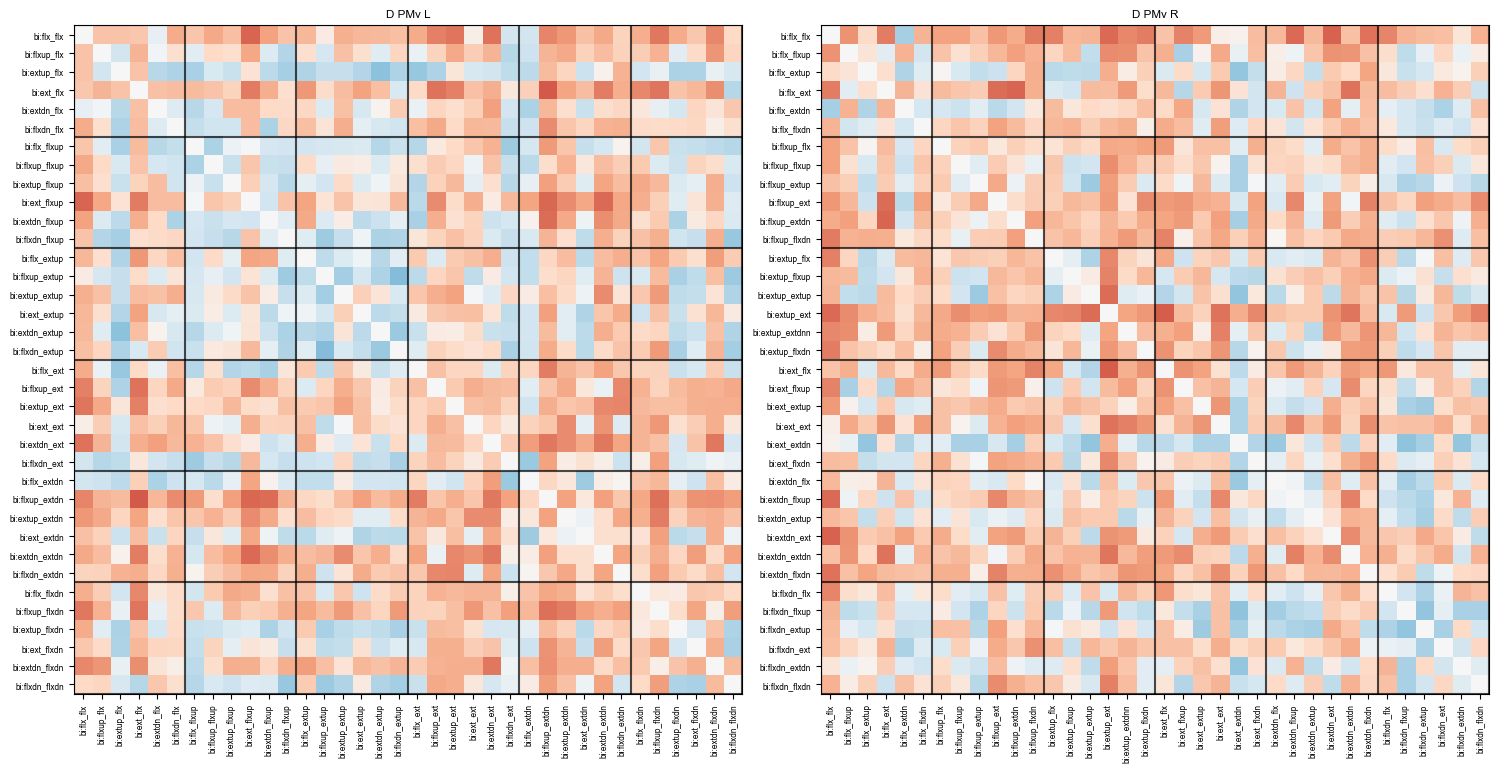

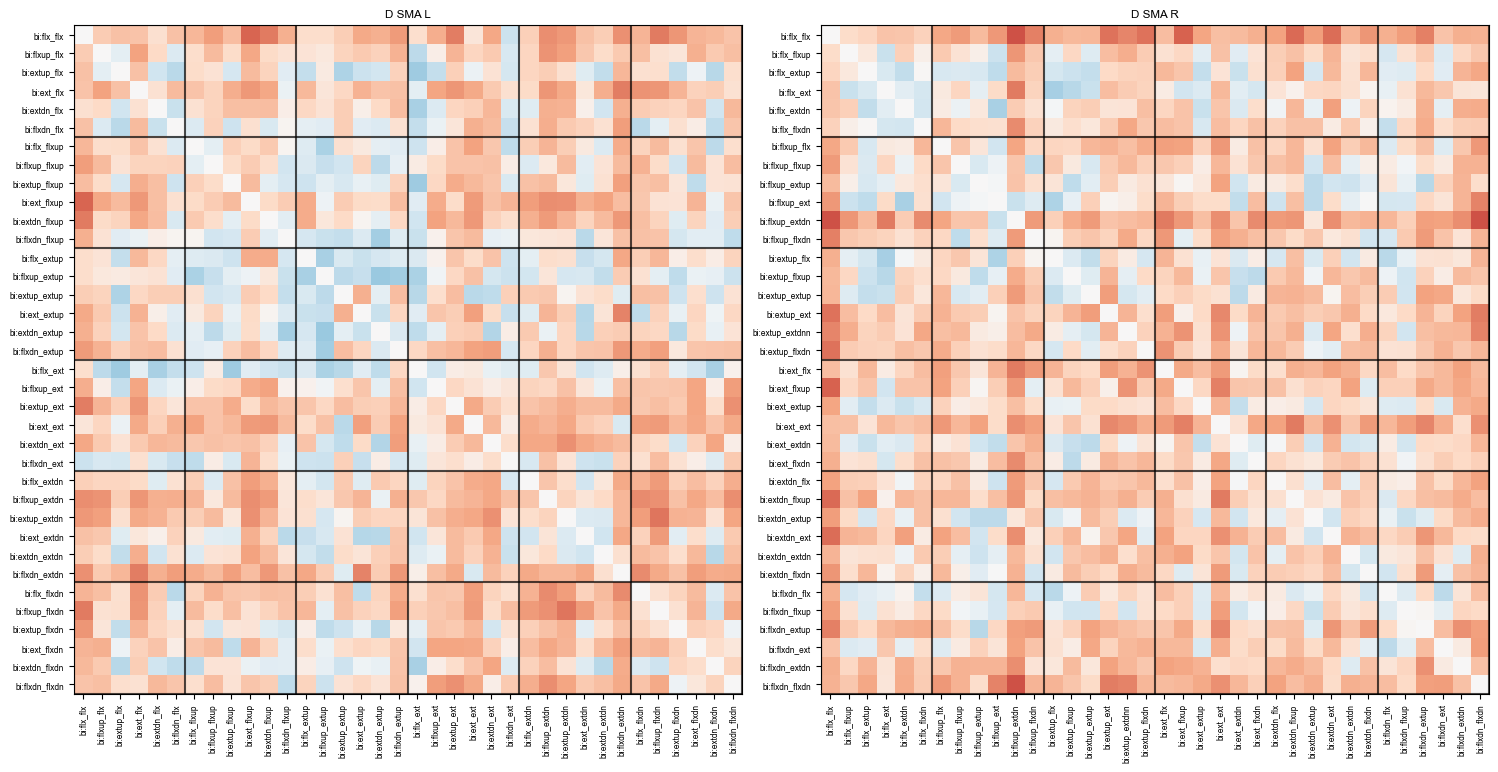

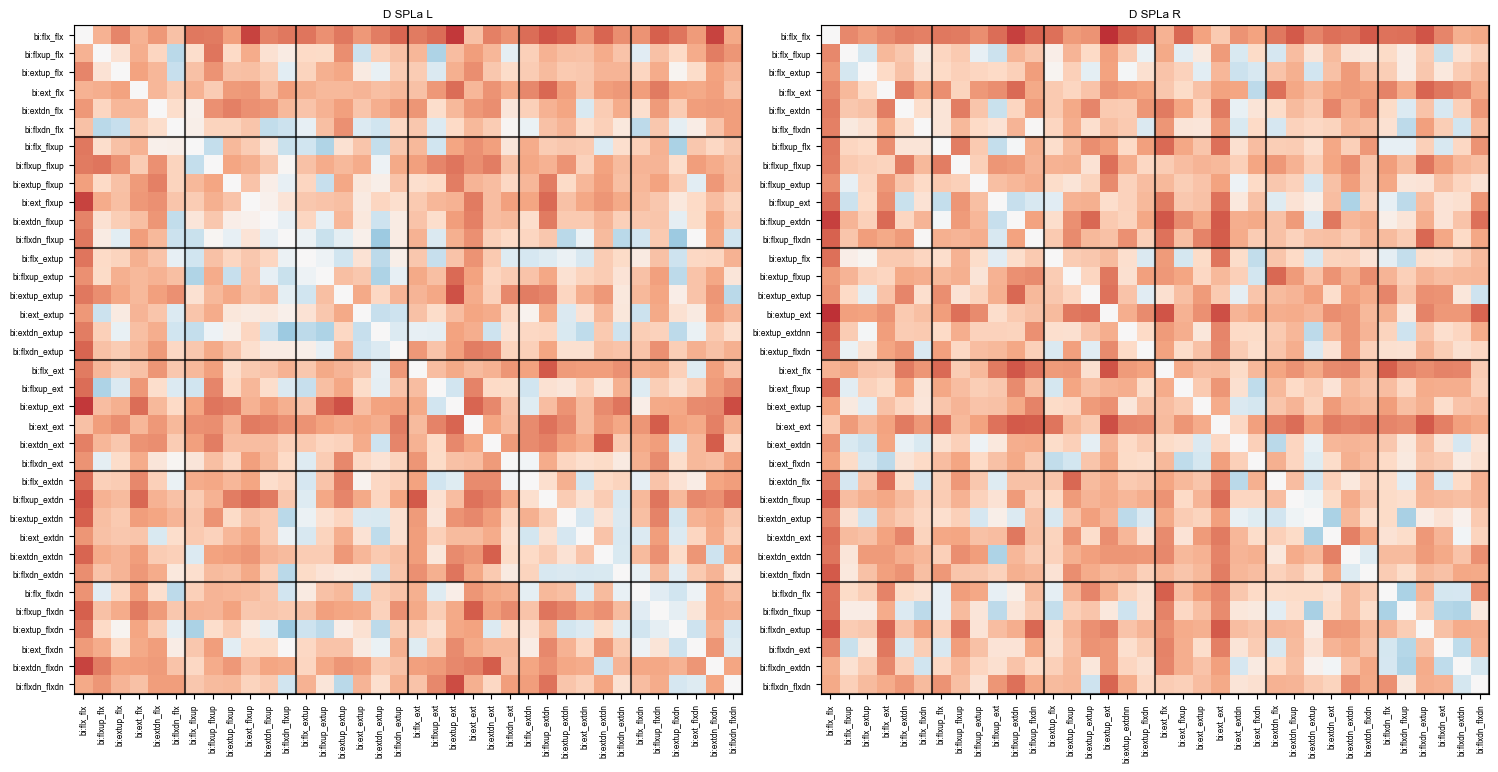

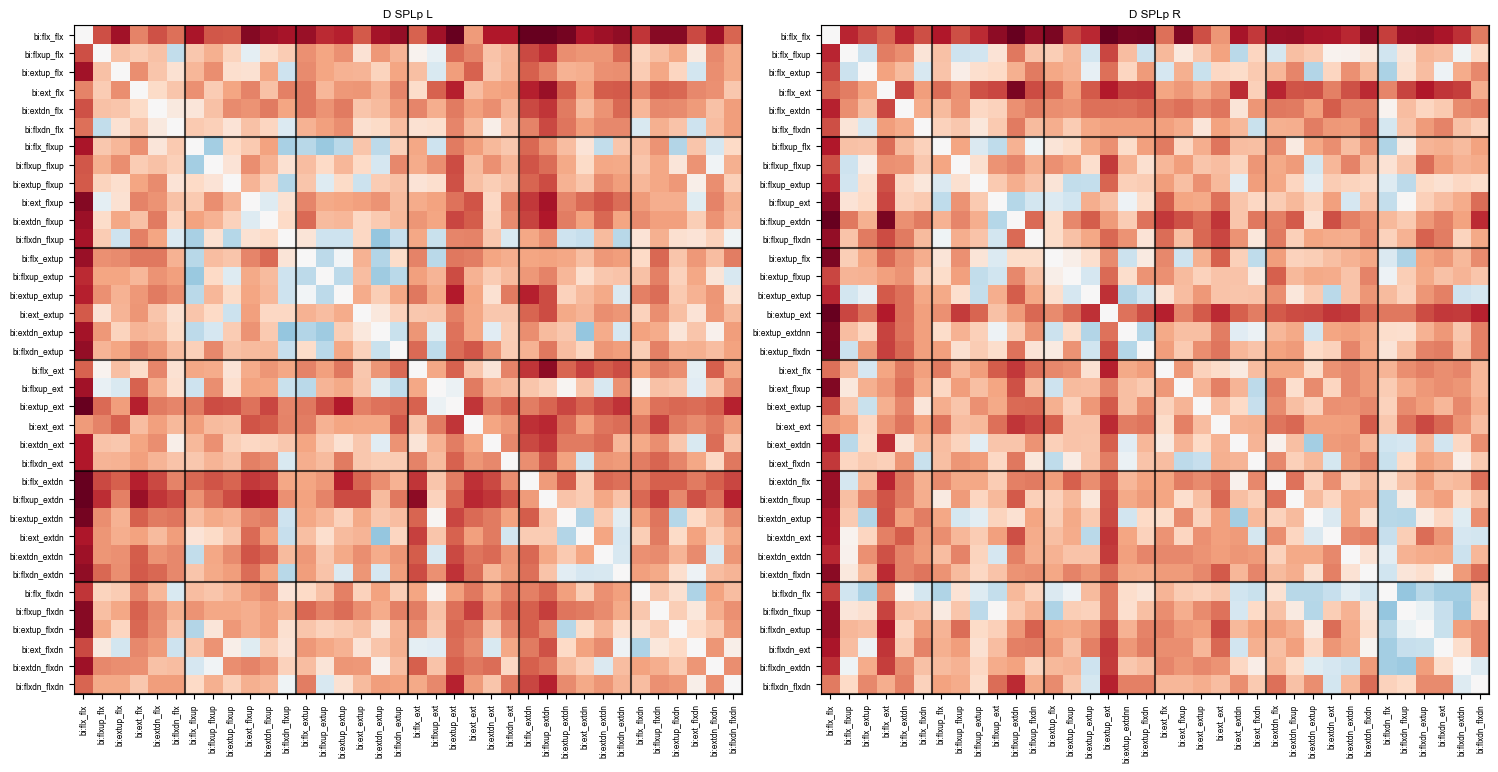

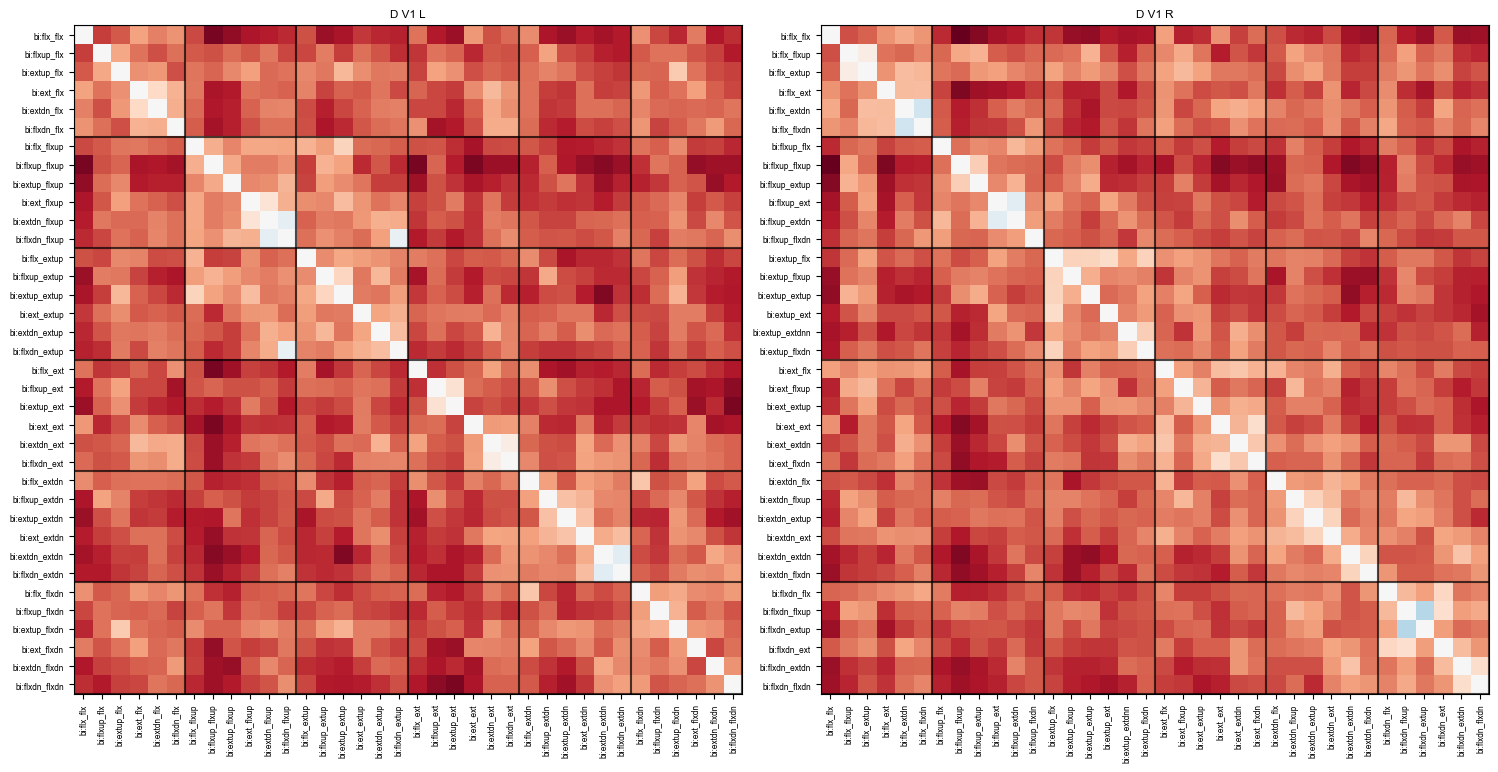

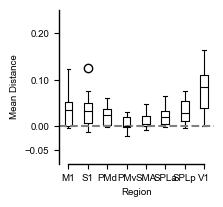

In [12]:
labels = {'L': ['bi:flx_flx', 'bi:flxup_flx', 'bi:extup_flx', 'bi:ext_flx', 'bi:extdn_flx', 'bi:flxdn_flx', 
                'bi:flx_flxup', 'bi:flxup_flxup', 'bi:extup_flxup', 'bi:ext_flxup', 'bi:extdn_flxup', 'bi:flxdn_flxup', 
                'bi:flx_extup', 'bi:flxup_extup', 'bi:extup_extup', 'bi:ext_extup', 'bi:extdn_extup', 'bi:flxdn_extup', 
                'bi:flx_ext', 'bi:flxup_ext', 'bi:extup_ext', 'bi:ext_ext', 'bi:extdn_ext', 'bi:flxdn_ext', 
                'bi:flx_extdn', 'bi:flxup_extdn', 'bi:extup_extdn', 'bi:ext_extdn', 'bi:extdn_extdn', 'bi:flxdn_extdn', 
                'bi:flx_flxdn', 'bi:flxup_flxdn', 'bi:extup_flxdn', 'bi:ext_flxdn', 'bi:extdn_flxdn', 'bi:flxdn_flxdn' ],

          'R': ['bi:flx_flx',    'bi:flx_flxup',   'bi:flx_extup',   'bi:flx_ext',   'bi:flx_extdn',   'bi:flx_flxdn',
                'bi:flxup_flx',  'bi:flxup_flxup', 'bi:flxup_extup', 'bi:flxup_ext', 'bi:flxup_extdn', 'bi:flxup_flxdn',
                'bi:extup_flx',  'bi:extup_flxup', 'bi:extup_extup', 'bi:extup_ext', 'bi:extup_extdnn', 'bi:extup_flxdn',
                'bi:ext_flx',    'bi:ext_flxup',   'bi:ext_extup',   'bi:ext_ext',   'bi:ext_extdn',   'bi:ext_flxdn',
                'bi:extdn_flx',  'bi:extdn_flxup', 'bi:extdn_extup', 'bi:extdn_ext', 'bi:extdn_extdn', 'bi:extdn_flxdn',
                'bi:flxdn_flx',  'bi:flxdn_flxup', 'bi:flxdn_extup', 'bi:flxdn_ext', 'bi:flxdn_extdn', 'bi:flxdn_flxdn']
}

cmap = 'RdBu_r'
sn_bad = []
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
df = {'sn':[], 'roi':[], 'hem':[], 'distances':[], 'mean_distance':[]}

RDMs_bi = {'region':[], 'labels': [], 'G': [], 'D': []}

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
for i_region, region in enumerate(regions):
    fig, axes = plt.subplots(1, 2, figsize=(15,8))
    # enumerate hemispheres so we get an integer index for axes
    for hem_idx, hem in enumerate(['L','R']):
        roi = f'{region}_{hem}'
        data, cond_vec, part_vec = [], [], []
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        if hem == 'R':
            cond_vec_tmp = d['cond_num_vec'][indices]
        else:
            cond_vec_tmp = d['cond_num_lhem_bimanual_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            # Filter for the current condition
            idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'bi' in c]
            Y = data_tmp[i_sub][idx, :]
            subj_cond = cond_vec_tmp[i_sub][idx]
            subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

        Y = []
        # --- RDM Calculation ---
        for i_sub in range(len(data)):
            obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
            Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
        
        N = len(Y)
        ncond = 36
        G_hat = np.zeros((N, ncond, ncond))
        for i_sub in range(N):
            G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                        Y[i_sub].obs_descriptors['cond_vec'],
                                                        Y[i_sub].obs_descriptors['part_vec'],
                                                        X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
            
            dist = pcm.G_to_dist(G_hat[i_sub, :, :])
            dist = np.sign(dist) * np.sqrt(np.abs(dist))
            # select the upper triangle of d excluding the diagonal
            triu_indices = np.triu_indices(ncond, k=1)
            d_upper = dist[triu_indices]
            # save in df:
            df['distances'].append(d_upper)
            df['mean_distance'].append(np.mean(d_upper))
            df['roi'].append(region)
            df['sn'].append(subject[i_sub])
            df['hem'].append(hem)

        G_hat_avg = np.mean(G_hat, axis=0)
        D_avg = pcm.G_to_dist(G_hat_avg)
        D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
        RDMs_bi['region'].append(region)
        RDMs_bi['G'].append(G_hat_avg)
        RDMs_bi['D'].append(D_avg)
        RDMs_bi['labels'].append(labels[hem])

        vmin = -0.18
        vmax = 0.18
        axes[hem_idx].imshow(D_avg, cmap=cmap, vmin=vmin, vmax=vmax)
        # plt.colorbar(axes[i_region].imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=axes[i_region])
        axes[hem_idx].set_title(f'D {region} {hem}')
        axes[hem_idx].set_xticks(list(range(36)))
        axes[hem_idx].set_yticks(list(range(36)))
        axes[hem_idx].set_yticklabels(labels[hem], fontsize=6)
        axes[hem_idx].set_xticklabels(labels[hem], rotation=90, fontsize=6)
        # Add thin borders delineating each 6x6 block
        block = 6
        bounds = [i * block - 0.5 for i in range(ncond // block + 1)]
        for b in bounds:
            axes[hem_idx].axhline(b, color='k', lw=1.5, alpha=0.7)
            axes[hem_idx].axvline(b, color='k', lw=1.5, alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'/Users/aghavamp/Desktop/Projects/bimanual_wrist/figures/RDMs/bi_{region}.pdf', bbox_inches='tight')
    plt.show()


df_bi = pd.DataFrame(df)
# Create a dot plot for the mean distances
fig, ax = plt.subplots(figsize=(2, 2))
sns.boxplot(data=df_bi, x='roi', y='mean_distance', ax=ax, fill=False, color='black', width=0.4, linewidth=0.8)
ax.axhline(0, color='grey', linestyle='--', linewidth=1.5)
ax.set_xlabel('Region')
ax.set_ylabel('Mean Distance')
plt.ylim(-0.08, 0.25)
ax.set_yticks([-0.05, 0, 0.1, 0.2])
utils.please.make_it_pretty(ax)
plt.savefig('/Users/aghavamp/Desktop/Projects/bimanual_wrist/figures/RDMs/avgdist_bi.pdf', bbox_inches='tight')
plt.show()

RDMs_bi = pd.DataFrame(RDMs_bi)
RDMs_bi.to_pickle(os.path.join(analysisDir, 'RDMs_bi.pkl'))



# Marginal 6by6

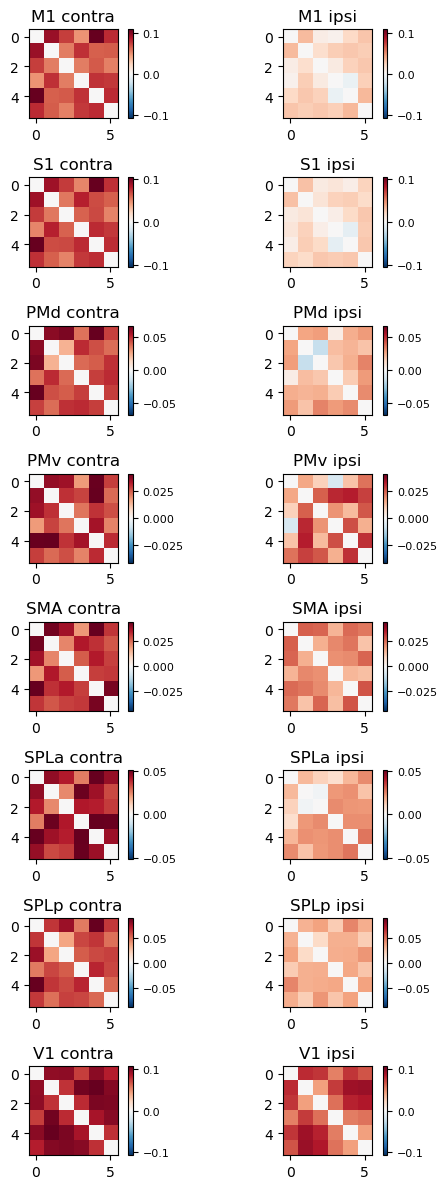

In [ ]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r' 
sn_bad = [102, 103]

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
dataset_marginal_within = {'region':[], 'hem': [], 'type': [], 'labels': [], 'Y': []}

for region in regions:
    conditions = ['lhand_marginal', 'rhand_marginal', 'lhand_marginal', 'rhand_marginal']
    rois = [f'{region}_R',f'{region}_L',f'{region}_L',f'{region}_R']
    for roi, condition in zip(rois, conditions):
        data, cond_vec, part_vec = [], [], []
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]
        
        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]
        
        for i_sub in range(len(subject)):
            # Filter for the current condition
            if condition == 'lhand_marginal':
                if roi.endswith('_R'):
                    cond_type = 'contra'
                else:
                    cond_type = 'ipsi'
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that left hand goes in that direction:
                        tmp_name = f'bi:{direction}_'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'lhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'rhand_marginal':
                if roi.endswith('_L'):
                    cond_type = 'contra'
                else:
                    cond_type = 'ipsi'
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that right hand goes in that direction:
                        tmp_name = f'_{direction}'
                        idx1 = np.array([tmp.endswith(tmp_name) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'rhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

        Y = []
        for i_sub in range(len(data)):
            obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
            Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

        # save PCM dataset:
        dataset_marginal_within['region'].append(region)
        dataset_marginal_within['hem'].append(roi[-1])
        dataset_marginal_within['type'].append(cond_type)
        dataset_marginal_within['labels'].append(labels)
        dataset_marginal_within['Y'].append(Y)
        
dataset_marginal_within = pd.DataFrame(dataset_marginal_within)
dataset_marginal_within.to_pickle(os.path.join(analysisDir, 'dataset_marginal_within.pkl'))

# --- RDM Calculation ---
fig, axes = plt.subplots(len(regions), 2, figsize=(6,12))
for i, region in enumerate(regions):
    subset = dataset_marginal_within[(dataset_marginal_within['region'] == f'{region}') & 
                                        (dataset_marginal_within['type'] == 'contra')]
    Y1 = subset['Y'].iloc[0]
    Y2 = subset['Y'].iloc[1]
    Y = Y1 + Y2  # concatenate the two lists of datasets
    labels = subset['labels'].iloc[0]
    N = len(Y)
    ncond = len(labels)
    G_hat = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                    Y[i_sub].obs_descriptors['cond_vec'],
                                                    Y[i_sub].obs_descriptors['part_vec'],
                                                    X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
    
    G_hat_avg = np.mean(G_hat, axis=0)
    D_avg = pcm.G_to_dist(G_hat_avg)
    D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
    vmin = -np.max(np.abs(D_avg))
    vmax = np.max(np.abs(D_avg))
    axes[i, 0].imshow(D_avg,vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[i, 0], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    axes[i, 0].set_title(f'{region} contra')

    subset = dataset_marginal_within[(dataset_marginal_within['region'] == f'{region}') & 
                                        (dataset_marginal_within['type'] == 'ipsi')]
    Y1 = subset['Y'].iloc[0]
    Y2 = subset['Y'].iloc[1]
    Y = Y1 + Y2  # concatenate the two lists of datasets
    labels = subset['labels'].iloc[0]
    N = len(Y)
    ncond = len(labels)
    G_hat = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                    Y[i_sub].obs_descriptors['cond_vec'],
                                                    Y[i_sub].obs_descriptors['part_vec'],
                                                    X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
    G_hat_avg = np.mean(G_hat, axis=0)
    D_avg = pcm.G_to_dist(G_hat_avg)
    D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
    axes[i, 1].imshow(D_avg,vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[i, 1], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    axes[i, 1].set_title(f'{region} ipsi')

plt.tight_layout()
plt.show()



# Marginal Average

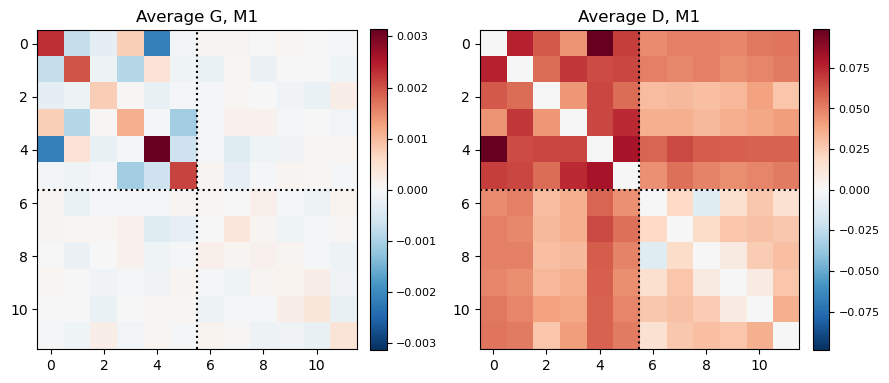

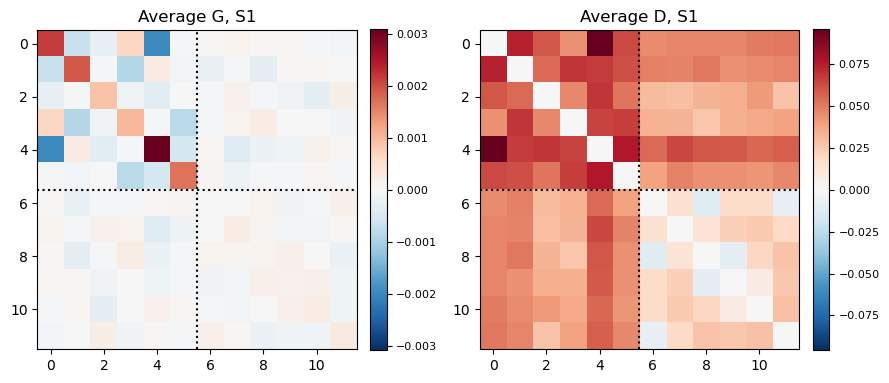

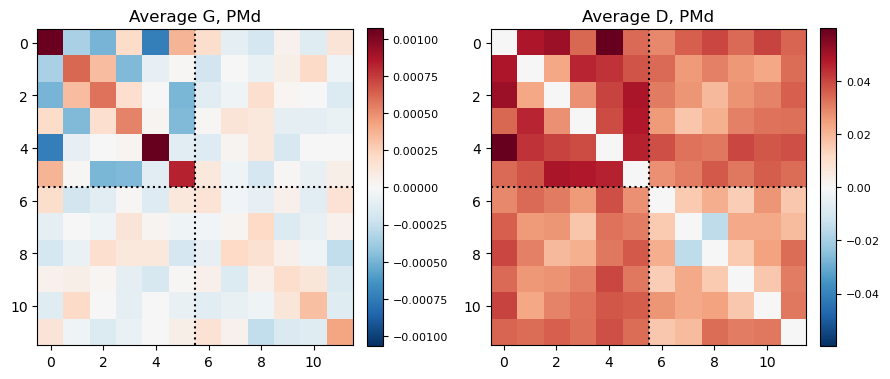

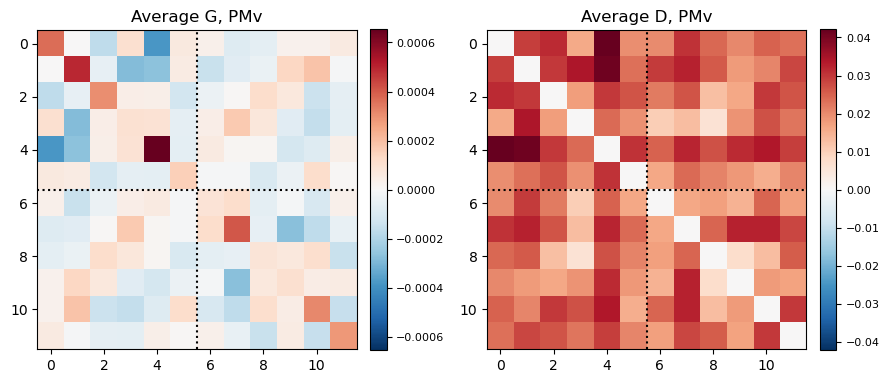

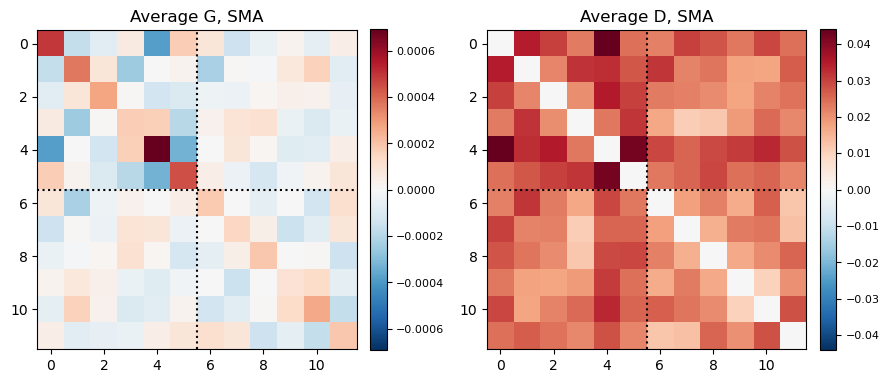

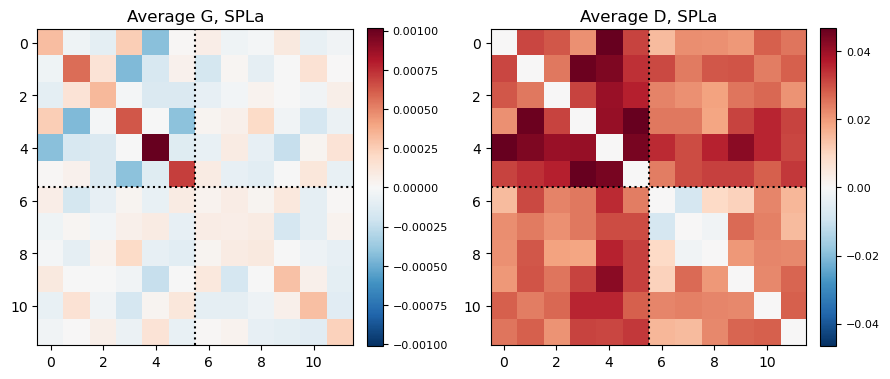

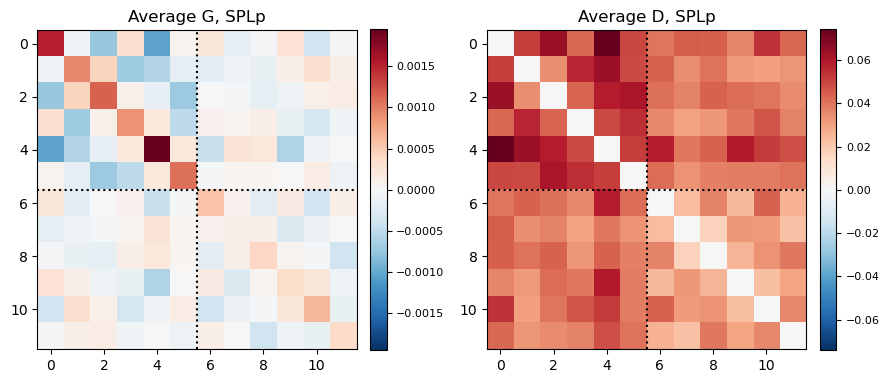

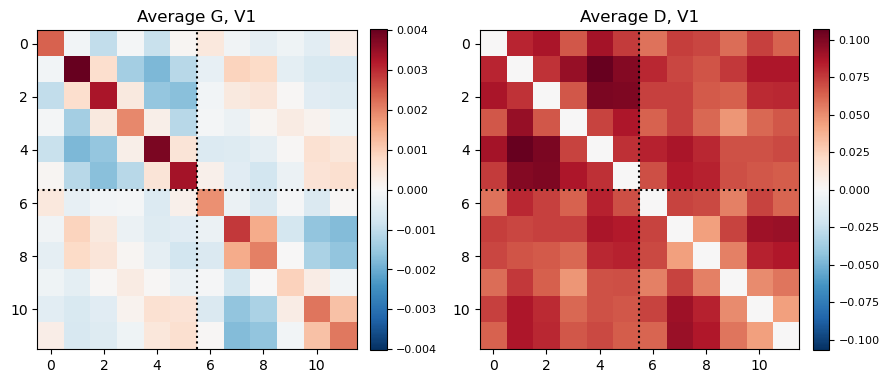

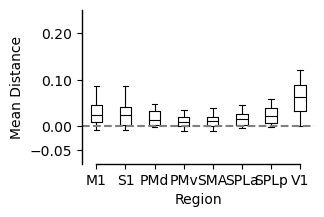

/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_15279/1654412521.py:165: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


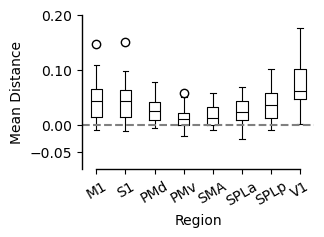

/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_15279/1654412521.py:176: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


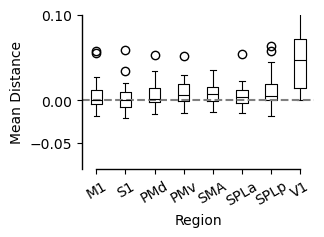


Region: M1
ipsi: t=1.81, p=0.0414
contra: t=5.85, p=0.0000

Region: S1
ipsi: t=0.95, p=0.1761
contra: t=5.52, p=0.0000

Region: PMd
ipsi: t=2.20, p=0.0192
contra: t=5.46, p=0.0000

Region: PMv
ipsi: t=2.73, p=0.0060
contra: t=3.16, p=0.0022

Region: SMA
ipsi: t=2.89, p=0.0042
contra: t=4.08, p=0.0002

Region: SPLa
ipsi: t=1.99, p=0.0293
contra: t=5.20, p=0.0000

Region: SPLp
ipsi: t=2.83, p=0.0047
contra: t=5.64, p=0.0000

Region: V1
ipsi: t=5.81, p=0.0000
contra: t=7.69, p=0.0000


In [ ]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
sn_bad = [102, 103]
df = {'sn':[], 'roi':[], 'hem':[], 'distances':[], 'mean_distance':[], 'mean_contra':[], 'mean_ipsi':[]}
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

hem = ['L', 'R']
for region in regions:
    data, cond_vec, part_vec = [], [], []
    for i_hem, h in enumerate(hem):
        roi = f'{region}_{h}'
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]
        
        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]
        
        for i_sub in range(len(subject)):
            Y = []
            subj_part = []
            subj_cond = []

            # lhand marginal:
            for cond_num, direction in enumerate(labels):
                # in each partition:
                for k in range(1,11):
                    # bimanual trials that left hand goes in that direction:
                    tmp_name = f'bi:{direction}_'
                    idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                    idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                    idx = idx1 & idx2
                    y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                condition_name = f'lhand:{direction}'
                # find the condition numbers corresponding to this condition:
                idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            # rhand marginal:
            for cond_num, direction in enumerate(labels):
                # in each partition:
                for k in range(1,11):
                    # bimanual trials that right hand goes in that direction:
                    tmp_name = f'_{direction}'
                    idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                    idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                    idx = idx1 & idx2
                    y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                condition_name = f'rhand:{direction}'
                # find the condition numbers corresponding to this condition:
                idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            subj_cond = np.array(subj_cond)
            # Sort based on Hemisphere to have contralateral first:
            if h == 'L':
                tmp = subj_cond.copy()
                subj_cond[tmp > 5] = tmp[tmp > 5] - 6
                subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 

            data.append(Y)
            cond_vec.append(subj_cond)
            part_vec.append(subj_part)

    Y = []
    # --- Build dataset ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    # --- RDM Calculation ---
    N = len(Y)
    ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
    G_hat = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                    Y[i_sub].obs_descriptors['cond_vec'],
                                                    Y[i_sub].obs_descriptors['part_vec'],
                                                    X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
        dist = pcm.G_to_dist(G_hat[i_sub, :, :])
        dist = np.sign(dist) * np.sqrt(np.abs(dist))
        # select the upper triangle of d excluding the diagonal
        triu_indices = np.triu_indices(ncond, k=1)
        d_upper = dist[triu_indices]
        df['distances'].append(d_upper)
        df['mean_distance'].append(np.mean(d_upper))

        # contra:
        dist = pcm.G_to_dist(G_hat[i_sub, :, :])
        dist = np.sign(dist) * np.sqrt(np.abs(dist))
        dist = dist[:6, :6]
        triu_indices = np.triu_indices(6, k=1)
        d_upper = dist[triu_indices]
        df['mean_contra'].append(np.mean(d_upper))

        # ipsi:
        dist = pcm.G_to_dist(G_hat[i_sub, :, :])
        dist = np.sign(dist) * np.sqrt(np.abs(dist))
        dist = dist[6:12, 6:12]
        triu_indices = np.triu_indices(6, k=1)
        d_upper = dist[triu_indices]
        df['mean_ipsi'].append(np.mean(d_upper))
        
        df['roi'].append(region)
        df['sn'].append(i_sub)
        df['hem'].append(hem)
        
    # avg G:
    fig, ax = plt.subplots(1,2,figsize=(9,4))
    G_hat_avg = np.mean(G_hat, axis=0)
    vmax = np.abs(G_hat_avg).max()
    ax[0].imshow(G_hat_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax[0].set_title(f'Average G, {region}')
    ax[0].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
    ax[0].axvline(5.5, color='k', linestyle=':', linewidth=1.5)

    # avg D:
    D_avg = pcm.G_to_dist(G_hat_avg)
    D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
    vmax = np.abs(D_avg).max()
    ax[1].imshow(D_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax[1].set_title(f'Average D, {region}')
    ax[1].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
    ax[1].axvline(5.5, color='k', linestyle=':', linewidth=1.5)

    plt.tight_layout()
    plt.show() 

df_marginal = pd.DataFrame(df)

# Create a dot plot for the mean distances
fig, ax = plt.subplots(figsize=(3, 2))
sns.boxplot(data=df_marginal, x='roi', y='mean_distance', ax=ax, fill=False, color='black', width=0.4, linewidth=0.8)
ax.axhline(0, color='grey', linestyle='--', linewidth=1.5)
ax.set_xlabel('Region')
ax.set_ylabel('Mean Distance')
plt.ylim(-0.08, 0.25)
ax.set_yticks([-0.05, 0, 0.1, 0.2])
utils.please.make_it_pretty(ax)
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
sns.boxplot(data=df_marginal, x='roi', y='mean_contra', ax=ax, fill=False, color='black', width=0.4, linewidth=0.8)
ax.axhline(0, color='grey', linestyle='--', linewidth=1.5)
ax.set_xlabel('Region')
ax.set_ylabel('Mean Distance')
plt.ylim(-0.08, 0.2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_yticks([-0.05, 0, 0.1, 0.2])
utils.please.make_it_pretty(ax)
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
sns.boxplot(data=df_marginal, x='roi', y='mean_ipsi', ax=ax, fill=False, color='black', width=0.4, linewidth=0.8)
ax.axhline(0, color='grey', linestyle='--', linewidth=1.5)
ax.set_xlabel('Region')
ax.set_ylabel('Mean Distance')
plt.ylim(-0.08, 0.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_yticks([-0.05, 0, 0.1])
utils.please.make_it_pretty(ax)
plt.show()

# t-test on mean_ipsi > 0:
from scipy import stats
for region in regions:
    print(f'\nRegion: {region}')
    tmp = df_marginal[df_marginal['roi'] == region]
    t, p = stats.ttest_1samp(tmp['mean_ipsi'], 0, alternative='greater')
    print(f'ipsi: t={t:.2f}, p={p:.4f}')
    tmp = df_marginal[df_marginal['roi'] == region]
    t, p = stats.ttest_1samp(tmp['mean_contra'], 0, alternative='greater')
    print(f'contra: t={t:.2f}, p={p:.4f}')



# avg distance plot

In [13]:
# combine df_contra, df_ipsi and df_bi and add a column 'lateral' to indicate
df_contra['lateral'] = 'contra'
df_ipsi['lateral'] = 'ipsi'
df_bi['lateral'] = 'bi'
df_combined = pd.concat([df_contra, df_ipsi, df_bi])
df_combined.to_csv(os.path.join(analysisDir, 'avg_distances.csv'))


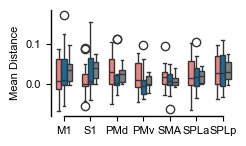

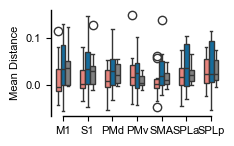

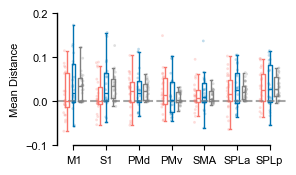

M1 contra t-test: t = 3.07, p = 0.0027
M1 ipsi t-test: t = 1.41, p = 0.0863
M1 bi t-test: t = 5.59, p = 0.0000
S1 contra t-test: t = 3.19, p = 0.0020
S1 ipsi t-test: t = 1.51, p = 0.0717
S1 bi t-test: t = 5.72, p = 0.0000
PMd contra t-test: t = 2.80, p = 0.0051
PMd ipsi t-test: t = 2.21, p = 0.0189
PMd bi t-test: t = 6.34, p = 0.0000
PMv contra t-test: t = 1.50, p = 0.0730
PMv ipsi t-test: t = 2.51, p = 0.0098
PMv bi t-test: t = 2.83, p = 0.0044
SMA contra t-test: t = 2.24, p = 0.0174
SMA ipsi t-test: t = 1.80, p = 0.0426
SMA bi t-test: t = 3.94, p = 0.0003
SPLa contra t-test: t = 3.20, p = 0.0020
SPLa ipsi t-test: t = 2.45, p = 0.0111
SPLa bi t-test: t = 5.99, p = 0.0000
SPLp contra t-test: t = 3.38, p = 0.0013
SPLp ipsi t-test: t = 3.62, p = 0.0007
SPLp bi t-test: t = 6.45, p = 0.0000


In [16]:
df = pd.read_csv(os.path.join(analysisDir, 'avg_distances.csv'))
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8

df = df[df.roi != 'V1']

fig, ax = plt.subplots(figsize=(2.5,1.5))
sns.boxplot(data=df[df.hem=='L'], x='roi', y='mean_distance', hue='lateral', ax=ax, width=0.6, palette=['#F8766D','#0072B2','#808080'], hue_order=['ipsi','contra','bi'],legend=False,
            order=['M1','S1','PMd','PMv','SMA','SPLa','SPLp'])
# plt.ylim((0,0.8))
# plt.title(f'Left Hemisphere')
plt.ylabel('Mean Distance')
plt.xlabel('')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()
plt.savefig(f'../figures/RDMs/mean_distance_leftHemisphere.pdf', bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(2.5,1.5))
sns.boxplot(data=df[df.hem=='R'], x='roi', y='mean_distance', hue='lateral', ax=ax, width=0.6, palette=['#F8766D','#0072B2','#808080'],  hue_order=['ipsi','contra','bi'], legend=False,
            order=['M1','S1','PMd','PMv','SMA','SPLa','SPLp'])
# plt.ylim((0,0.8))
# plt.title(f'Right Hemisphere')
plt.ylabel('Mean Distance')
plt.xlabel('')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()
plt.savefig(f'../figures/RDMs/mean_distance_rightHemisphere.pdf', bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(3,1.8))
sns.boxplot(data=df, x='roi', y='mean_distance', hue='lateral', ax=ax, width=0.6, palette=['#F8766D','#0072B2','#808080'],  hue_order=['ipsi','contra','bi'], legend=False,
            order=['M1','S1','PMd','PMv','SMA','SPLa','SPLp'], fliersize=0, linewidth=1, gap=0.4, fill=False)
sns.stripplot(data=df, x='roi', y='mean_distance', hue='lateral', ax=ax, palette=['#F8766D','#0072B2','#808080'],  hue_order=['ipsi','contra','bi'],
              order=['M1','S1','PMd','PMv','SMA','SPLa','SPLp'], dodge=True, size=2, alpha=0.25, legend=False)
ax.axhline(0, color='grey', linestyle='--', linewidth=1.5, alpha=0.7)
plt.ylim((-0.1,0.2))
ax.set_yticks([-0.1, 0, 0.1, 0.2])
# plt.title(f'Right Hemisphere')
plt.ylabel('Mean Distance')
plt.xlabel('')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()
plt.savefig(f'../figures/RDMs/mean_distance.pdf', bbox_inches="tight")
plt.show()

# ttest against 0 for every region within each lateral category
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

for region in df['roi'].unique():
    for lateral in df['lateral'].unique():
        data = df[(df['roi'] == region) & (df['lateral'] == lateral)]['mean_distance']
        t_stat, p_val = ttest_1samp(data, 0, alternative='greater')
        print(f'{region} {lateral} t-test: t = {t_stat:.2f}, p = {p_val:.4f}')



# Stats within ROI

In [138]:
from statsmodels.stats.anova import AnovaRM
# Multiple-comparisons corrections
from statsmodels.stats.multitest import multipletests
# Post-hoc paired t-tests for all condition pairs
from itertools import combinations
from scipy import stats

regions = ['SMA','PMv','PMd','M1','S1','SPLa','SPLp']
lateral = ['ipsi','contra','bi']

for region in regions:
    print(f'\n{region}:')
    for cond in lateral:
        df_tmp = df[(df.roi==region) & (df.lateral==cond)]
        # ttest within lateral condition against 0:
        t_stat, p_val = stats.ttest_1samp(df_tmp['mean_distance'], 0)
        print(f'   {cond}: t({df_tmp.shape[0]-1})={t_stat:.3f} p={p_val:.3f}')




SMA:
   ipsi: t(27)=2.014 p=0.054
   contra: t(27)=2.311 p=0.029
   bi: t(27)=3.938 p=0.001

PMv:
   ipsi: t(27)=2.623 p=0.014
   contra: t(27)=1.514 p=0.142
   bi: t(27)=2.826 p=0.009

PMd:
   ipsi: t(27)=2.210 p=0.036
   contra: t(27)=3.210 p=0.003
   bi: t(27)=6.345 p=0.000

M1:
   ipsi: t(27)=1.645 p=0.112
   contra: t(27)=3.540 p=0.001
   bi: t(27)=5.587 p=0.000

S1:
   ipsi: t(27)=1.338 p=0.192
   contra: t(27)=3.508 p=0.002
   bi: t(27)=5.724 p=0.000

SPLa:
   ipsi: t(27)=2.213 p=0.036
   contra: t(27)=3.002 p=0.006
   bi: t(27)=5.993 p=0.000

SPLp:
   ipsi: t(27)=3.339 p=0.002
   contra: t(27)=2.866 p=0.008
   bi: t(27)=6.454 p=0.000
